In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.optimize

from datetime import datetime
import pytz

import gm2
import trfp

Welcome to JupyROOT 6.12/04


In [2]:
STATION_BARCODE_PHI = [350.17, 354.33, 358.84, 4.34, 9.33,
                       14.23, 20.2, 23.32, 29.33, 34.33, 39.33,
                       43.31, 50.2, 53.31, 59.34, 64.33, 69.34,
                       73.3, 80.17, 83.32, 89.31, 94.33, 99.31,
                       103.3, 110.19, 113.31, 119.34, 124.32,
                       129.3, 133.27, 140.21, 143.38, 149.34,
                       154.33, 159.36, 163.31, 170.19, 173.39,
                       179.36, 184.35, 189.36, 193.31, 200.17,
                       203.38, 209.34, 214.31, 219.34, 223.32,
                       230.22, 233.42, 239.36, 244.34, 249.38,
                       253.34, 260.2, 263.47, 269.35, 274.34,
                       279.38, 283.41, 290.19, 293.37, 299.34,
                       304.31, 309.34, 313.29, 320.19, 323.41,
                       329.33, 334.35, 339.35, 343.41]

STATION_BARCODE_EDGES = (STATION_BARCODE_PHI+np.roll(STATION_BARCODE_PHI,1))/2
if STATION_BARCODE_EDGES[3] >= 180.:  # accounts for wrap around at station 3
    STATION_BARCODE_EDGES[3] = STATION_BARCODE_EDGES[3]-180.
else:
    STATION_BARCODE_EDGES[3] = STATION_BARCODE_EDGES[3]+180.
STATION_BARCODE_EDGES = np.append(STATION_BARCODE_EDGES, STATION_BARCODE_EDGES[0])

In [7]:
STATION_BARCODE_PHI = [350.17, 354.33, 358.84, 4.34, 9.33,
                       14.23, 20.2, 23.32, 29.33, 34.33, 39.33,
                       43.31, 50.2, 53.31, 59.34, 64.33, 69.34,
                       73.3, 80.17, 83.32, 89.31, 94.33, 99.31,
                       103.3, 110.19, 113.31, 119.34, 124.32,
                       129.3, 133.27, 140.21, 143.38, 149.34,
                       154.33, 159.36, 163.31, 170.19, 173.39,
                       179.36, 184.35, 189.36, 193.31, 200.17,
                       203.38, 209.34, 214.31, 219.34, 223.32,
                       230.22, 233.42, 239.36, 244.34, 249.38,
                       253.34, 260.2, 263.47, 269.35, 274.34,
                       279.38, 283.41, 290.19, 293.37, 299.34,
                       304.31, 309.34, 313.29, 320.19, 323.41,
                       329.33, 334.35, 339.35, 343.41]

STATION_BARCODE_EDGES = (STATION_BARCODE_PHI+np.roll(STATION_BARCODE_PHI,1))/2
if STATION_BARCODE_EDGES[3] >= 180.:  # accounts for wrap around at station 3
    STATION_BARCODE_EDGES[3] = STATION_BARCODE_EDGES[3]-180.
else:
    STATION_BARCODE_EDGES[3] = STATION_BARCODE_EDGES[3]+180.
STATION_BARCODE_EDGES = np.append(STATION_BARCODE_EDGES, STATION_BARCODE_EDGES[0])

STATION_BARCODE_EDGES[1] = STATION_BARCODE_PHI[1]
STATION_BARCODE_EDGES[2] = STATION_BARCODE_PHI[1]
STATION_BARCODE_EDGES[3] = STATION_BARCODE_PHI[3]
STATION_BARCODE_EDGES[4] = STATION_BARCODE_PHI[3]
STATION_BARCODE_EDGES[5] = STATION_BARCODE_PHI[5]
STATION_BARCODE_EDGES[6] = STATION_BARCODE_PHI[5]
STATION_BARCODE_EDGES[54] = STATION_BARCODE_PHI[54]
STATION_BARCODE_EDGES[55] = STATION_BARCODE_PHI[54]

print STATION_BARCODE_EDGES

[346.79  354.33  354.33    4.34    4.34   14.23   14.23   21.76   26.325
  31.83   36.83   41.32   46.755  51.755  56.325  61.835  66.835  71.32
  76.735  81.745  86.315  91.82   96.82  101.305 106.745 111.75  116.325
 121.83  126.81  131.285 136.74  141.795 146.36  151.835 156.845 161.335
 166.75  171.79  176.375 181.855 186.855 191.335 196.74  201.775 206.36
 211.825 216.825 221.33  226.77  231.82  236.39  241.85  246.86  251.36
 260.2   260.2   266.41  271.845 276.86  281.395 286.8   291.78  296.355
 301.825 306.825 311.315 316.74  321.8   326.37  331.84  336.85  341.38
 346.79 ]


In [8]:
def trolley_run_station_average(corrected_df):
    station_phi = STATION_BARCODE_PHI
    station_edges = STATION_BARCODE_EDGES

    # tr_phi is not monotonic, so sort by tr_phi

    corrected_df = corrected_df.sort_values(by=['tr_phi'])

    measured_phi = corrected_df['tr_phi'].values
    measured_extent = (np.roll(measured_phi,-1)-np.roll(measured_phi,1))/2
    measured_extent[0] = measured_extent[0]+180
    measured_extent[-1] = measured_extent[-1]+180
    # print np.max(measured_extent)

    corrected_df['tr_extent'] = pd.Series(measured_extent, index=corrected_df.index)
    corrected_df = corrected_df.sort_index()

    # for a given station:
    # create a mask for when trolley is in [low edge, high edge)
    tr_baseline = np.empty([72,17])
    fp_baseline = np.empty([72,6])
    summed_azimuth = np.empty(72)
    summed_pts = np.empty(72)
    baseline_time = np.empty(72)
    tr_baseline[:] = np.nan
    fp_baseline[:] = np.nan
    summed_azimuth[:] = np.nan
    summed_pts[:] = np.nan
    baseline_time[:] = np.nan

    for st in range(72): 
        if station_edges[st+1] > station_edges[st]:
            mask = (corrected_df['tr_phi'] >= station_edges[st]) & (corrected_df['tr_phi'] < station_edges[st+1])
        else:  # case where we go over the 360 deg line
            mask = (corrected_df['tr_phi'] >= station_edges[st]) | (corrected_df['tr_phi'] < station_edges[st+1])

        out_df = corrected_df[mask]
        summed_pts[st] = out_df.shape[0]
        summed_azimuth[st] = sum(out_df['tr_extent'].values)        
        baseline_time[st] = sum(out_df.index.values)/summed_pts[st]

        for m in range(17):
            st_id = 'tr,m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                tr_baseline[st, m] = sum(out_df['tr_extent'].values*out_df[st_id].values)/sum(out_df['tr_extent'].values)
            else:
                tr_baseline[st, m] = np.nan
        for m in range(6):
            st_id = 'st'+str(st)+',m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                fp_baseline[st, m] = np.mean(out_df[st_id])
            else:
                fp_baseline[st, m] = np.nan
    
    return tr_baseline, fp_baseline, baseline_time, summed_azimuth, summed_pts

In [20]:
vetos = [25]
output = np.zeros((7,4))
ii = 0
for veto_extent in vetos:

    def remove_trolley_effect(trolley_moment_df):
        '''DOC STRING'''
        barcode = STATION_BARCODE_PHI

        trolley_effect_removed_df = trolley_moment_df.copy()

        for st in range(72):
            print '\rRemoving trolley image from station ' + str(st) + '.',
            for m in range(1,7):
                st_m = 'st' + str(st) + ",m" + str(m)

                # Unwrap the fixed probe data versus trolley position
                raw_data = trolley_moment_df[['tr_phi', st_m]].copy()
                raw_low = raw_data.copy()
                raw_high = raw_data.copy()
                raw_low['tr_phi'] = raw_low['tr_phi'] - 360
                raw_high['tr_phi'] = raw_high['tr_phi'] + 360
                unwrap_nomask_df = pd.concat([raw_low, raw_data, raw_high])

                unwrap_mask_df = unwrap_nomask_df.copy()
    #             # change mask to exclude 15 degrees instead of 7 (4 more degrees in either direction)
    #             mask = ((unwrap_nomask_df['tr_phi']>barcode[st]-6) & (unwrap_nomask_df['tr_phi']<barcode[st]+9) |
    #                     (unwrap_nomask_df['tr_phi']>barcode[st]-6-360) & (unwrap_nomask_df['tr_phi']<barcode[st]+9-360) |
    #                     (unwrap_nomask_df['tr_phi']>barcode[st]-6+360) & (unwrap_nomask_df['tr_phi']<barcode[st]+9+360))
                # change mask to exclude 22 degrees
                veto_adjust = (veto_extent-7)/2
                mask = ((unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust) |
                        (unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust-360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust-360) |
                        (unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust+360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust+360))
                unwrap_mask_df[st_m] = unwrap_nomask_df[st_m].mask(mask)
                unwrap_mask_df['tr_phi'] = unwrap_nomask_df['tr_phi']

                unwrap_filled_df = unwrap_mask_df.copy()
                temp = unwrap_filled_df.rolling(int(500),win_type='triang',min_periods=1,center=True).mean()
                temp = temp.rolling(int(500),win_type='triang',min_periods=1,center=True).mean()
                unwrap_filled_df[st_m] = unwrap_filled_df[st_m].mask(mask, temp[st_m])

                length = raw_data.shape[0]
                filled_df = unwrap_filled_df.iloc[length:2*length,:]

                trolley_effect_removed_df[st_m] = filled_df[st_m]

        print '\rFinished removing trolley images from ' + str(length) + ' events.'
        return trolley_effect_removed_df

    station_phi = STATION_BARCODE_PHI
    station_edges = STATION_BARCODE_EDGES

    corrected_df_1 = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_moment_df'))
    tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, _ = trolley_run_station_average(corrected_df_1)

    corrected_df_2 = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_2.h5', key='run_3997_moment_df'))
    tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, _ = trolley_run_station_average(corrected_df_2)

    # load all fixed probe runs moment_df into one big moment_df (runs 3959--3994)
    print 'Appending fixed probe runs.'
    fp_moment_df = pd.read_hdf('60hr_fixed_probe_runs.h5', key='run_3959_moment_df')
    pts = fp_moment_df.shape[0]
    for run in np.arange(3959, 3995):
        temp_df = pd.read_hdf('60hr_fixed_probe_runs.h5', key='run_'+str(run)+'_moment_df')
        pts = pts + temp_df.shape[0]
        print '\rAppending run ' + str(run) + '.',
        fp_moment_df = fp_moment_df.append(temp_df)

    # load all the trolley runs corrected_df into on big file (to show window of 60hr set) ()
    print '\nAppending trolley runs.'
    tr_corrected_df = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3955_moment_df'))
    for run in np.arange(3956, 3959):
        temp_df = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_'+str(run)+'_moment_df'))
        pts = pts + temp_df.shape[0]
        print '\rAppending run ' + str(run) + '.',
        tr_corrected_df = tr_corrected_df.append(temp_df)
    for run in np.arange(3995, 3999):
        temp_df = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_2.h5', key='run_'+str(run)+'_moment_df'))
        pts = pts + temp_df.shape[0]
        print '\rAppending run ' + str(run) + '.',
        tr_corrected_df = tr_corrected_df.append(temp_df)

    print '\nDone appending runs.'

    ### Apply baseline corrections, generate virtual trolley measurements

    fp_moment_baseline = fp_moment_df.copy()
    fp_moment_tr_run_baseline = tr_corrected_df.copy()

    # apply baseline corrections to each fp stm
    print "\nSubtracting fixed probe baselines."
    for st in np.arange(72):
        num_probes = len(trfp.STATION_PROBE_ID[st])
        for m in np.arange(num_probes):
            stm = 'st'+str(st)+',m'+str(m+1)

            def backwards_correction(time):
                c1 = fp_baseline_1[st, m]
                c2 = fp_baseline_2[st, m]
                t1 = baseline_time_1[st]
                t2 = baseline_time_2[st]
                return (c2-c1)/(t2-t1)*(time-t1) + c1

            correction = backwards_correction(fp_moment_baseline.index.values)
            fp_moment_baseline[stm] = fp_moment_baseline[stm] - correction
            correction = backwards_correction(fp_moment_tr_run_baseline.index.values)
            fp_moment_tr_run_baseline[stm] = fp_moment_tr_run_baseline[stm] - correction

            print '\rstm: ' + stm + '.',

    # replace columns in vtr with Jacobian-fixed columns from fp baseline correction

    print "\n\nApplying Jacobian."
    vtr_df = fp_moment_df.copy()
    vtr_tr_run_df = tr_corrected_df.copy()

    for st in np.arange(72):
        num_probes = len(trfp.STATION_PROBE_ID[st])
        if num_probes == 4:
            num_moments = 4
            if st == 41:
                J = trfp.J_4_PROBE_ST41
            elif st == 37 | st == 39:
                J = trfp.J_4_PROBE_ST37_ST39
            else:
                J = trfp.J_4_PROBE
        else:
            num_moments = 5
            if st < 7:
                J = trfp.J_6_PROBE_OFFSET
            else:
                J = trfp.J_6_PROBE
        # run over each vtr moment:
        for m in np.arange(num_moments):
            vtr_stm = 'st'+str(st)+',m'+str(m+1)
            fp_stm = ['st'+str(st)+',m'+str(fp_m+1) for fp_m in np.arange(num_moments)]
            vtr_df[vtr_stm] = fp_moment_baseline[fp_stm].dot(J[m])
            vtr_tr_run_df[vtr_stm] = fp_moment_tr_run_baseline[fp_stm].dot(J[m])

            print '\rstm: ' + stm + '.',

    # Add trolley baseline correction (with backwards correction)
    print "\n\nAdding trolley baselines."

    for st in np.arange(72):
        num_probes = len(trfp.STATION_PROBE_ID[st])
        for m in np.arange(num_probes):
            stm = 'st'+str(st)+',m'+str(m+1)

            def backwards_correction(time):
                c1 = tr_baseline_1[st, m]
                c2 = tr_baseline_2[st, m]
                t1 = baseline_time_1[st]
                t2 = baseline_time_2[st]
                return (c2-c1)/(t2-t1)*(time-t1) + c1

            correction = backwards_correction(vtr_df.index.values)
            vtr_df[stm] = vtr_df[stm] + correction
            correction = backwards_correction(vtr_tr_run_df.index.values)
            vtr_tr_run_df[stm] = vtr_tr_run_df[stm] + correction

            print '\rstm: ' + stm + '.',

    print '\n\nDone.'


Finished removing trolley images from 4382 events.                                                            
Finished removing trolley images from 4359 events.                                                            
Appending fixed probe runs.
Appending run 3994.                              
Appending trolley runs.
Finished removing trolley images from 893 events.                 
Finished removing trolley images from 4382 events.                                                            
Finished removing trolley images from 2977 events.                                                            
Finished removing trolley images from 539 events.              
Finished removing trolley images from 365 events.         
Finished removing trolley images from 921 events.                          
Finished removing trolley images from 4359 events.                                                            
Finished removing trolley images from 2853 events.                           

In [21]:

# bin into the agreed upon bins

bins = np.arange(1524384055, 1524641055, 1000)-500
bin_centers = np.arange(1524384055, 1524640055, 1000)

# bins = np.arange(1524383560, 1524640850, 10)-5
# bin_centers = np.arange(1524383560, 1524640840, 10)

vtr_time_bin_df = vtr_df.groupby(pd.cut(vtr_df.index,bins)).mean()
vtr_time_bin_df.index = bin_centers
vtr_time_bin_df.head()


# print vtr_time_bin_df.iloc[[0,-1]]
# print vtr_time_bin_df.shape
# print bin_centers.shape

test_df = vtr_time_bin_df.copy()

azi_avg_df = pd.DataFrame(np.zeros((test_df.shape[0],6)),
                         index = test_df.index,
                         columns = ['m' + str(m) for m in np.arange(6)+1])

weight = summed_azimuth_1+summed_azimuth_2
weight[1] = 0
weight[3] = 0
weight[5] = 0
weight[54] = 0
total_weight = np.sum(weight)

for m in np.arange(6):
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_df['m'+str(m+1)] = test_df[stm_list].multiply(weight).sum(axis=1)/total_weight

output[ii, 0] = veto_extent
output[ii, 1] = azi_avg_df.loc[1524639055]['m1']
output[ii, 2] = azi_avg_df.loc[1524639055]['m2']
output[ii, 3] = azi_avg_df.loc[1524639055]['m3']

print output
ii += 1

[[2.50000000e+01 5.19577841e+04 1.07353705e+01 2.25960758e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [16]:
print weight

[15.061456    0.         20.03196469  0.         19.72908926  0.
 15.08226499  9.10824415 11.0825201   9.94716392  8.99174427 10.88205553
 10.01417026  9.07012388 11.0046902  10.0258806   8.91350383 10.89464589
 10.03694611  9.16754766 10.96765172 10.06203878  8.94944697 10.875956
  9.96210086  9.11909527 11.06364255  9.99898715  8.89423536 10.83486902
 10.12413469  9.15416744 10.93553174 10.10870414  8.92548672 10.93541943
  9.92081068  9.27442161 10.86447577 10.06802141  8.97059588 10.81854651
 10.02446538  9.1802359  10.9244397  10.06198351  8.94882272 10.90016752
 10.02336146  9.22970573 10.87080019 10.0679962   8.99983172 17.69789848
  0.         12.37217771 10.86521423 10.00466612  9.16733271 10.79882857
  9.85421942  9.23511136 10.92846382  9.9970347   8.99898129 10.81267087
 10.13436904  9.12941148 10.909384   10.04445488  9.13930798 10.80631223]


In [22]:
review_df = azi_avg_df[['m1', 'm2', 'm3', 'm5']].copy()

review_df['m1_unc'] = 0.116
review_df['m2_unc'] = 0.060
review_df['m3_unc'] = 0.062
review_df['m5_unc'] = 0.100

review_df['m1'] = review_df['m1']/61.79
review_df['m2'] = review_df['m2']/61.79
review_df['m3'] = review_df['m3']/61.79
review_df['m5'] = review_df['m5']/61.79

review_df = review_df.reindex(sorted(review_df.columns), axis=1)

# review_df.head()

# review_df.to_csv('purcell_may22_25degveto.csv', float_format='%0.4f', index_label='time')

In [23]:
# all_stations = review_df.copy()
removed_stations = review_df.copy()

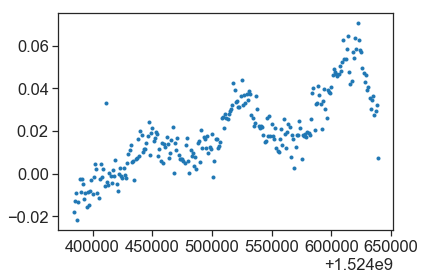

In [24]:
plt.plot(all_stations.index.values, all_stations['m1']-removed_stations['m1'], '.')

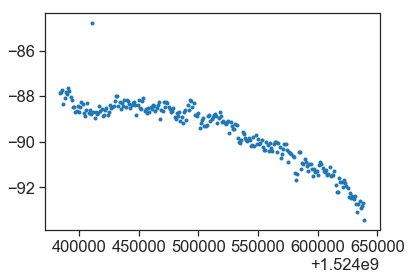

In [27]:
plt.plot(all_stations.index.values, all_stations['m5']*61.79*72/45, '.')

In [ ]:
def trolley_run_station_average(corrected_df):
    station_phi = STATION_BARCODE_PHI
    station_edges = STATION_BARCODE_EDGES

    # tr_phi is not monotonic, so sort by tr_phi

    corrected_df = corrected_df.sort_values(by=['tr_phi'])

    measured_phi = corrected_df['tr_phi'].values
    measured_extent = (np.roll(measured_phi,-1)-np.roll(measured_phi,1))/2
    measured_extent[0] = measured_extent[0]+180
    measured_extent[-1] = measured_extent[-1]+180
    # print np.max(measured_extent)

    corrected_df['tr_extent'] = pd.Series(measured_extent, index=corrected_df.index)
    corrected_df = corrected_df.sort_index()

    # for a given station:
    # create a mask for when trolley is in [low edge, high edge)
    tr_baseline = np.empty([72,17])
    fp_baseline = np.empty([72,6])
    summed_azimuth = np.empty(72)
    summed_pts = np.empty(72)
    baseline_time = np.empty(72)
    tr_baseline[:] = np.nan
    fp_baseline[:] = np.nan
    summed_azimuth[:] = np.nan
    summed_pts[:] = np.nan
    baseline_time[:] = np.nan

    for st in range(72): 
        if station_edges[st+1] > station_edges[st]:
            mask = (corrected_df['tr_phi'] >= station_edges[st]) & (corrected_df['tr_phi'] < station_edges[st+1])
        else:  # case where we go over the 360 deg line
            mask = (corrected_df['tr_phi'] >= station_edges[st]) | (corrected_df['tr_phi'] < station_edges[st+1])

        out_df = corrected_df[mask]
        summed_pts[st] = out_df.shape[0]
        summed_azimuth[st] = sum(out_df['tr_extent'].values)        
        baseline_time[st] = sum(out_df.index.values)/summed_pts[st]

        for m in range(17):
            st_id = 'tr,m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                tr_baseline[st, m] = sum(out_df['tr_extent'].values*out_df[st_id].values)/sum(out_df['tr_extent'].values)
            else:
                tr_baseline[st, m] = np.nan
        for m in range(6):
            st_id = 'st'+str(st)+',m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                fp_baseline[st, m] = np.mean(out_df[st_id])
            else:
                fp_baseline[st, m] = np.nan
    
    return tr_baseline, fp_baseline, baseline_time, summed_azimuth, summed_pts

def remove_trolley_effect(trolley_moment_df):
    '''DOC STRING'''
    barcode = STATION_BARCODE_PHI

    trolley_effect_removed_df = trolley_moment_df.copy()

    for st in range(72):
        print '\rRemoving trolley image from station ' + str(st) + '.',
        for m in range(1,7):
            st_m = 'st' + str(st) + ",m" + str(m)

            # Unwrap the fixed probe data versus trolley position
            raw_data = trolley_moment_df[['tr_phi', st_m]].copy()
            raw_low = raw_data.copy()
            raw_high = raw_data.copy()
            raw_low['tr_phi'] = raw_low['tr_phi'] - 360
            raw_high['tr_phi'] = raw_high['tr_phi'] + 360
            unwrap_nomask_df = pd.concat([raw_low, raw_data, raw_high])

            unwrap_mask_df = unwrap_nomask_df.copy()
            # change mask to exclude 15 degrees
            veto_adjust = (15.-7.)/2.
            mask = ((unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust) |
                    (unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust-360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust-360) |
                    (unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust+360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust+360))
            unwrap_mask_df[st_m] = unwrap_nomask_df[st_m].mask(mask)
            unwrap_mask_df['tr_phi'] = unwrap_nomask_df['tr_phi']

            unwrap_filled_df = unwrap_mask_df.copy()
            temp = unwrap_filled_df.rolling(int(500),win_type='triang',min_periods=1,center=True).mean()
            temp = temp.rolling(int(500),win_type='triang',min_periods=1,center=True).mean()
            unwrap_filled_df[st_m] = unwrap_filled_df[st_m].mask(mask, temp[st_m])

            length = raw_data.shape[0]
            filled_df = unwrap_filled_df.iloc[length:2*length,:]

            trolley_effect_removed_df[st_m] = filled_df[st_m]

    print '\rFinished removing trolley images from ' + str(length) + ' events.'
    return trolley_effect_removed_df

station_phi = STATION_BARCODE_PHI
station_edges = STATION_BARCODE_EDGES

corrected_df_1 = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_moment_df'))
tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, _ = trolley_run_station_average(corrected_df_1)

corrected_df_2 = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_2.h5', key='run_3997_moment_df'))
tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, _ = trolley_run_station_average(corrected_df_2)

# load all fixed probe runs moment_df into one big moment_df (runs 3959--3994)
print 'Appending fixed probe runs.'
fp_moment_df = pd.read_hdf('60hr_fixed_probe_runs.h5', key='run_3959_moment_df')
pts = fp_moment_df.shape[0]
for run in np.arange(3959, 3995):
    temp_df = pd.read_hdf('60hr_fixed_probe_runs.h5', key='run_'+str(run)+'_moment_df')
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    fp_moment_df = fp_moment_df.append(temp_df)

# load all the trolley runs corrected_df into on big file (to show window of 60hr set) ()
print '\nAppending trolley runs.'
tr_corrected_df = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3955_moment_df'))
for run in np.arange(3956, 3959):
    temp_df = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_'+str(run)+'_moment_df'))
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    tr_corrected_df = tr_corrected_df.append(temp_df)
for run in np.arange(3995, 3999):
    temp_df = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_2.h5', key='run_'+str(run)+'_moment_df'))
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    tr_corrected_df = tr_corrected_df.append(temp_df)

print '\nDone appending runs.'

### Apply baseline corrections, generate virtual trolley measurements

fp_moment_baseline = fp_moment_df.copy()
fp_moment_tr_run_baseline = tr_corrected_df.copy()

# apply baseline corrections to each fp stm
print "\nSubtracting fixed probe baselines."
for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    for m in np.arange(num_probes):
        stm = 'st'+str(st)+',m'+str(m+1)

        def backwards_correction(time):
            c1 = fp_baseline_1[st, m]
            c2 = fp_baseline_2[st, m]
            t1 = baseline_time_1[st]
            t2 = baseline_time_2[st]
            return (c2-c1)/(t2-t1)*(time-t1) + c1

        correction = backwards_correction(fp_moment_baseline.index.values)
        fp_moment_baseline[stm] = fp_moment_baseline[stm] - correction
        correction = backwards_correction(fp_moment_tr_run_baseline.index.values)
        fp_moment_tr_run_baseline[stm] = fp_moment_tr_run_baseline[stm] - correction

        print '\rstm: ' + stm + '.',

# replace columns in vtr with Jacobian-fixed columns from fp baseline correction

print "\n\nApplying Jacobian."
vtr_df = fp_moment_df.copy()
vtr_tr_run_df = tr_corrected_df.copy()

for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    if num_probes == 4:
        num_moments = 4
        if st == 41:
            J = trfp.J_4_PROBE_ST41
        elif st == 37 | st == 39:
            J = trfp.J_4_PROBE_ST37_ST39
        else:
            J = trfp.J_4_PROBE
    else:
        num_moments = 5
        if st < 7:
            J = trfp.J_6_PROBE_OFFSET
        else:
            J = trfp.J_6_PROBE
    # run over each vtr moment:
    for m in np.arange(num_moments):
        vtr_stm = 'st'+str(st)+',m'+str(m+1)
        fp_stm = ['st'+str(st)+',m'+str(fp_m+1) for fp_m in np.arange(num_moments)]
        vtr_df[vtr_stm] = fp_moment_baseline[fp_stm].dot(J[m])
        vtr_tr_run_df[vtr_stm] = fp_moment_tr_run_baseline[fp_stm].dot(J[m])

        print '\rstm: ' + stm + '.',

# Add trolley baseline correction (with backwards correction)
print "\n\nAdding trolley baselines."

for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    for m in np.arange(num_probes):
        stm = 'st'+str(st)+',m'+str(m+1)

        def backwards_correction(time):
            c1 = tr_baseline_1[st, m]
            c2 = tr_baseline_2[st, m]
            t1 = baseline_time_1[st]
            t2 = baseline_time_2[st]
            return (c2-c1)/(t2-t1)*(time-t1) + c1

        correction = backwards_correction(vtr_df.index.values)
        vtr_df[stm] = vtr_df[stm] + correction
        correction = backwards_correction(vtr_tr_run_df.index.values)
        vtr_tr_run_df[stm] = vtr_tr_run_df[stm] + correction

        print '\rstm: ' + stm + '.',

print '\n\nDone.'

# bin into the agreed upon bins

In [ ]:
bins = np.arange(1524384055, 1524641055, 1000)-500
bin_centers = np.arange(1524384055, 1524640055, 1000)

vtr_time_bin_df = vtr_df.groupby(pd.cut(vtr_df.index,bins)).mean()
vtr_time_bin_df.index = bin_centers

test_df = vtr_time_bin_df.copy()

azi_avg_df = pd.DataFrame(np.zeros((test_df.shape[0],6)),
                         index = test_df.index,
                         columns = ['m' + str(m) for m in np.arange(6)+1])

weight = summed_azimuth_1+summed_azimuth_2
weight[1] = 0
weight[3] = 0
weight[5] = 0
weight[54] = 0
total_weight = np.sum(weight)

for m in np.arange(6):
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_df['m'+str(m+1)] = test_df[stm_list].multiply(weight).sum(axis=1)/total_weight

In [ ]:
review_df = azi_avg_df[['m1', 'm2', 'm3', 'm5']].copy()

review_df['m1_unc'] = 0.116
review_df['m2_unc'] = 0.060
review_df['m3_unc'] = 0.062
review_df['m5_unc'] = 0.100

review_df['m1'] = review_df['m1']/61.79
review_df['m2'] = review_df['m2']/61.79
review_df['m3'] = review_df['m3']/61.79
review_df['m5'] = review_df['m5']/61.79

review_df = review_df.reindex(sorted(review_df.columns), axis=1)

review_df.head()

In [ ]:
review_df = azi_avg_df[['m1', 'm2', 'm3', 'm5']].copy()

review_df['m1_unc'] = 0.116
review_df['m2_unc'] = 0.060
review_df['m3_unc'] = 0.062
review_df['m5_unc'] = 0.100

review_df['m1'] = review_df['m1']/61.79
review_df['m2'] = review_df['m2']/61.79
review_df['m3'] = review_df['m3']/61.79
review_df['m5'] = review_df['m5']/61.79

review_df = review_df.reindex(sorted(review_df.columns), axis=1)

review_df.head()

In [ ]:
print weight

In [ ]:
drift_df = vtr_time_bin_df.iloc[0].copy()
m = ['st'+str(i)+',m1' for i in range(72)]
drift_df = drift_df[m]

for ii in range(72):
    stm = 'st'+str(ii)+',m1'
    drift_df[stm] = drift_df[stm] - tr_baseline_1[ii,0]

print np.max(drift_df.iloc[0])/61.79
print '\n'

print drift_df/61.79